### Challenge: Iterate and evaluate your classifier

*It's time to revisit your classifier from the previous assignment. Using the evaluation techniques we've covered here, look at your classifier's performance in more detail. Then go back and iterate by engineering new features, removing poor features, or tuning parameters. Repeat this process until you have five different versions of your classifier. Once you've iterated, answer these questions to compare the performance of each:*

- Do any of your classifiers seem to overfit?
- Which seem to perform the best? Why?
- Which features seemed to be most impactful to performance?

*Write up your iterations and answers to the above questions in a few pages. Submit a link below and go over it with your mentor to see if they have any other ideas on how you could improve your classifier's performance.*

In [2]:
# Import packages

%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import string
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

import nltk
#nltk.download('stopwords')  # required the first time 
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [3]:
# Load data and rename columns 

data = pd.read_csv("amazon_cells_labelled.txt", delimiter= '\t', header=None)
data.columns = ['review', 'pos']

In [4]:
data.head()

,review,pos
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


This dataset contains two columns. 

(1) "review": reviews from Amazon, which seems to be the review of a phone, 

(2) "pos": whether the reviews are positive or not. 

The following barcharts show equal number of positive and negative reviews, so we do not have class imbalance. 


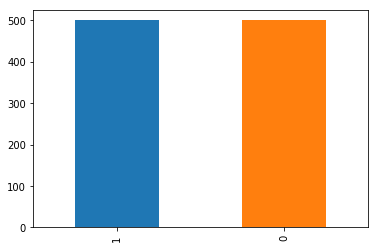

In [5]:
# Equal number of pos and neg, which shows that we don't have class imbalance
data.pos.value_counts().plot(kind='bar')

In the first version, I build a classifier on the basis of text analysis and linguistic features. I first tokenize all the words and select a subset after removing English stopwords and punctuations. I manually select words from the most frequent words that predict the nature of the reviews . Linguistically, adjective and adjectival modifiers ("intensifiers") are often a good indicator of emotions. Thus, I select top adjectives and intensifier to build a sparse matrix. I then run a Bernoulli Naive Bayes (because the output variable is binary) and crossvalidated accuracy scores for the model.

In [7]:
# use tokenizer to divide sentences into words, remove stopwords and punctuations

words = " ".join(data.review) #joined dataframe to create string to pass on to the word_tokenize

stop = set(stopwords.words('english'))
word_tokens = word_tokenize(words)  #split text into tokens 

tokenized_words = []
for word in word_tokens:
    if word.lower() not in stop and word.lower() not in string.punctuation:
        tokenized_words.append(word)
        
tokenized_count = Counter(tokenized_words).most_common()
tokenized_count[:20]


[('phone', 151),
 ("n't", 76),
 ('great', 67),
 ('good', 60),
 ('product', 51),
 ('quality', 44),
 ('headset', 44),
 ("'s", 43),
 ('use', 41),
 ('one', 39),
 ('sound', 37),
 ('well', 36),
 ('ear', 34),
 ('would', 34),
 ('battery', 33),
 ('work', 32),
 ('Great', 31),
 ('works', 31),
 ('...', 30),
 ('like', 30)]

### Classifier version: 1: Feature Engineering 

In [7]:
# Feature Engineering 
# Features one: adding frequent adjectives from reviews 

pos_keywords = ['good', 'best', 'excellent', 'fine', 'nice', 'great',
               'satisfied', 'fulfill', 'love', 'easy', 'happy', 
               'recommend', 'impressed', 'incredible', 'well', 'awesome', 'cool',
               'fantastic', 'sturdy' ]

# ':-)' in the keywords created an error

for key in pos_keywords:
    data[str(key)] = data.review.str.contains(' '+ str(key), case=False)

In [8]:
#Features two: Adding intensifiers 

pos_intensifiers = ['very', 'pretty', 'highly', 'really', 'perfectly']

for key in pos_intensifiers: 
    data[str(key)] = data.review.str.contains(' ' + str(key) + ' ', case=False)

In [9]:
data.head()  #Sparse Matrix

,review,pos,good,best,excellent,fine,nice,great,satisfied,fulfill,...,well,awesome,cool,fantastic,sturdy,very,pretty,highly,really,perfectly
0,So there is no way for me to plug it in here i...,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,"Good case, Excellent value.",1,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Great for the jawbone.,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Tied to charger for conversations lasting more...,0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,The mic is great.,1,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


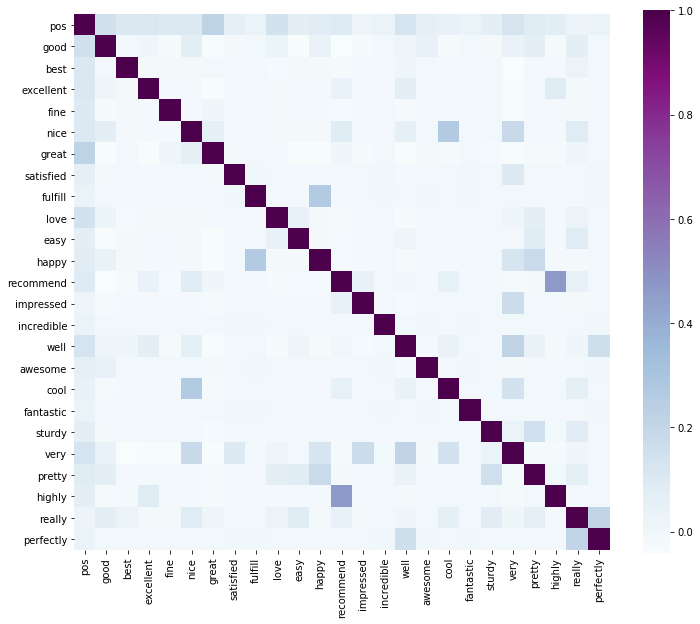

In [10]:
# Finding correlation between words

plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), cmap='BuPu', square=True)

The correlation matrix shows us that some words are prevalent in the reviews. For example, some of the words that are highly correlated with positive review are "great", "love", "well" etc. Some words and phrases that are highly correlated are - "highly recommend", "nice" and "cool", and as expected certain intensifier + adjective combinations (e.g., "very" with "well", "nice", "impressred"; "really" with "nice", "sturdy", "easy" etc.)

In [11]:
# Training data 

X = data[pos_keywords + pos_intensifiers]  # this looks like a sparse matrix, mostly zero and some 1s.
y = data.pos

In [12]:
# Binary data - Bernoulli

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB() # instantiate the classifier 

# fit model 
bnb.fit(X, y)  #learning which features correspond to a pos senting 

y_pred = bnb.predict(X)  #.predict in classifier, and .transform in feature selection 

In [13]:
# Cross validation scores 

scores = cross_val_score(bnb, X, y, cv=10)
print("Mean 10-fold cross-validated accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() *2))  #means


print("Number of mislabeled points out of total {} points: {}".format(
X.shape[0], (y != y_pred).sum()))  #FP + FN

# Confusion matrix 
print("The confusion matrix is as follows: \n" , confusion_matrix(y, y_pred))

Mean 10-fold cross-validated accuracy: 0.70 (+/- 0.10)
Number of mislabeled points out of total 1000 points: 293
The confusion matrix is as follows: 
 [[438  62]
 [231 269]]


Since the outcome variable has binary values, the model accuracy would around 50% if it had a random guess. Our cross-validated model accuracy is about 70%. This is not great but let us now find out the features that are most important. .coef_ attribute returns the feature values and np.argsort method returns the indices of such features sorted with ascending values. After performing the sorting we see that five most important features are 'great', 'very, 'good', 'well', and 'recommend'.

In [14]:
# Finding feature values and their indices 

bnb.coef_  #values

array([[-2.30657711, -3.32822836, -3.57954279, -3.65365076, -3.51054992,
        -2.09146573, -4.60916221, -5.52545294, -3.22286785, -3.65365076,
        -3.65365076, -3.12755767, -4.42684065, -5.52545294, -2.72209256,
        -4.60916221, -4.27268997, -5.52545294, -4.42684065, -2.19324843,
        -4.02137554, -4.13915858, -3.57954279, -5.52545294]])

In [15]:
bnb_idx = np.argsort(bnb.coef_)[0][::-1]  #accessing list within array and reversing it.
# [0][::-1] because argsort sorts indexes for its ascending values
bnb_idx

array([ 5, 19,  0, 14, 11,  8,  1,  4,  2, 22,  9,  3, 10, 20, 21, 16, 18,
       12,  6, 15,  7, 17, 13, 23])

In [16]:
#np.argsort(bnb.coef_)  #returns sorted indexes of values in ascending order

In [17]:
print("The important features are: {}".format(X.columns[bnb_idx]))

The important features are: Index(['great', 'very', 'good', 'well', 'recommend', 'love', 'best', 'nice',
       'excellent', 'really', 'easy', 'fine', 'happy', 'pretty', 'highly',
       'cool', 'sturdy', 'impressed', 'satisfied', 'awesome', 'fulfill',
       'fantastic', 'incredible', 'perfectly'],
      dtype='object')


### Classifier version 2: Using CountVectorizer with Bernoulli NB with alpha 

In the following version of the classifiers, I implement several sklearn feature extraction module and classifiers to do hyperparameter tuning before selecting the final version of the classifier. 

In [22]:
# Import countvectorizer 
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate CountVectorizer and create sparse matrix 
data_vec = CountVectorizer(stop_words='english')
X = data_vec.fit_transform(data.review)   # review string turned into sparse vectors by word frequency counts 
X.shape   #1000, 1642

(1000, 1642)

In [23]:
# Train test split (80-20) to train and test the classifiers

X_train, X_test, y_train, y_test = train_test_split(
    X, data.pos, test_size = .2)

# Each of these variables is a Series.

print([np.shape(X_train), np.shape(X_test)], y_train.shape, y_test.shape)

[(800, 1642), (200, 1642)] (800,) (200,)


In [24]:
# Bernoulli Naive Bayes with alpha

from sklearn import metrics

list_alpha = np.arange(1e-5, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
CV = np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = sklearn.naive_bayes.BernoulliNB(alpha=alpha)
    bayes.fit(X_train, y_train)  #training 
    score_train[count] = bayes.score(X_train, y_train)  #scoring training 
    score_test[count]= bayes.score(X_test, y_test)  # scoring test
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    CV[count] = (cross_val_score(bayes, X_train, y_train, cv=10)).mean() # doing CV on 10 divisions of the dataset. 
    count = count + 1 

In [25]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test, CV])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision', 'Mean Cross-validation'])
models.describe()

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision,Mean Cross-validation
count,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,9.955010,0.679670,0.576731,0.956753,0.543670,0.596956
std,5.795132,0.172511,0.118052,0.072928,0.091424,0.105821
min,0.000010,0.508750,0.465000,0.752688,0.465000,0.508751
25%,4.977510,0.513750,0.465000,0.924731,0.465000,0.510001
50%,9.955010,0.605000,0.517500,1.000000,0.490769,0.537442
75%,14.932510,0.858437,0.715000,1.000000,0.632908,0.699930
max,19.910010,0.976250,0.775000,1.000000,0.730769,0.796201


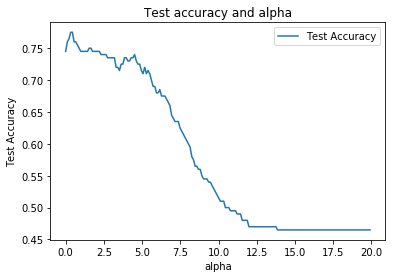

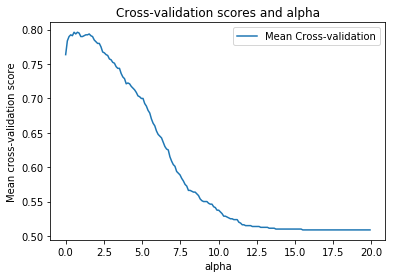

In [26]:
models.plot(x='alpha', y='Test Accuracy')   #plotting test accuracy as a function of alpha 
plt.ylabel('Test Accuracy')
plt.title('Test accuracy and alpha')
plt.show()

models.plot(x='alpha', y='Mean Cross-validation') 
plt.ylabel('Mean cross-validation score')
plt.title('Cross-validation scores and alpha')
plt.show()

From the above plots we see that the test accuracy and the mean cross-validation score decrease as alpha increases. Significantly, in both plots the peak y values are around when alpha = 5. In the next iteration of hyperparameter tuning, we will restrict the alpha values to 5. 

In [27]:
list_alpha = np.arange(1e-5, 5, .05)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
CV = np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = sklearn.naive_bayes.BernoulliNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    CV[count] = (cross_val_score(bayes, X_train, y_train, cv=10)).mean()
    count = count + 1 

In [28]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test, CV])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision', 'Mean Cross-validation'])
models.describe()

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision,Mean Cross-validation
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.475010,0.927287,0.741100,0.841075,0.681311,0.760401
std,1.450575,0.031985,0.013937,0.047858,0.027444,0.031544
min,0.000010,0.860000,0.715000,0.752688,0.632353,0.697380
25%,1.237510,0.901875,0.735000,0.806452,0.655058,0.731828
50%,2.475010,0.932500,0.740000,0.827957,0.681416,0.766245
75%,3.712510,0.956250,0.745000,0.881720,0.701923,0.790243
max,4.950010,0.976250,0.775000,0.924731,0.730769,0.797451


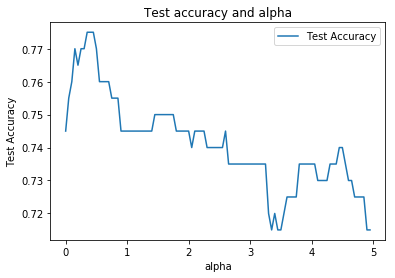

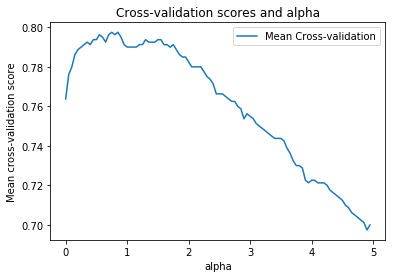

In [29]:
models.plot(x='alpha', y='Test Accuracy')   #plotting test accuracy as a function of alpha 
plt.ylabel('Test Accuracy')
plt.title('Test accuracy and alpha')
plt.show()

models.plot(x='alpha', y='Mean Cross-validation') 
plt.ylabel('Mean cross-validation score')
plt.title('Cross-validation scores and alpha')
plt.show()

The peak values of test accuracy is when alpha is around 0.5, whereas the peak accuracy score we get via 10-fold crossvalidation when alpha is around 2. Since cross-validation is a more robust indicator (i.e., it trains the model on 10 different subsets and the mean score is the average of such cross-validation scores, hence more robust than a single test-accuracy of the model), we'll consider the alpha from the mean cross-validation score. In the following interation, I consider the alpha around 2 to confirm. 

In [30]:
list_alpha = np.arange(1e-5, 2, .01)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
CV = np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = sklearn.naive_bayes.BernoulliNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    CV[count] = (cross_val_score(bayes, X_train, y_train, cv=10)).mean()
    count = count + 1 

In [31]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test, CV])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision', 'Mean Cross-validation'])

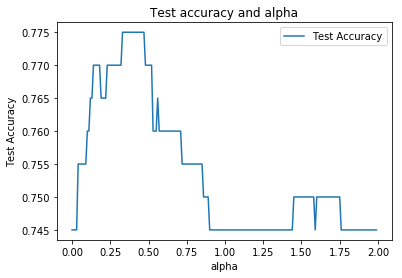

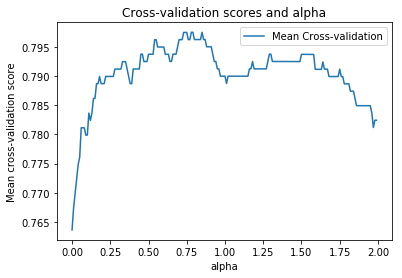

In [32]:
models.plot(x='alpha', y='Test Accuracy')   #plotting test accuracy as a function of alpha 
plt.ylabel('Test Accuracy')
plt.title('Test accuracy and alpha')
plt.show()

models.plot(x='alpha', y='Mean Cross-validation') 
plt.ylabel('Mean cross-validation score')
plt.title('Cross-validation scores and alpha')
plt.show()

This is confirmed by the scores above that alpha around 2 is the best parameter for this classifier. 


In [33]:
print("The alpha value for this bayes classifier is: ", bayes.alpha)

The alpha value for this bayes classifier is:  1.99001


In [46]:
#CV.mean()  #60%   # average of different alpha parameterss tested on the loop -- this is not what I want to look so. 

scores = cross_val_score(bnb, Xtf_train, ytf_train, cv=10)
print("Mean 10-fold cross-validated accuracy from Bernoulli NB with tfidf: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() *2))  #means
# 69% was 56%
print(bayes.alpha)

Mean 10-fold cross-validated accuracy from Bernoulli NB with tfidf: 0.78 (+/- 0.11)
1.99001


## Classifier version 3: Bernoulli NB with tfidfVectorizer

In this version of the classifier, I am experimenting with the TfIdf vectorizer that converts raw frequency scores to tfidf features. [here](resources here)

In [35]:
# First, transforming data_vec (matrix with raw frequency counts) to tfidf matrix

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X)

X_tfidf.shape

(1000, 1642)

In [36]:
# Splitting train and test subsets on X_tfidf 

Xtf_train, Xtf_test, ytf_train, ytf_test = train_test_split(
    X_tfidf, data.pos, test_size = .2)

print(Xtf_train.shape, Xtf_test.shape, ytf_train.shape, ytf_test.shape)

(800, 1642) (200, 1642) (800,) (200,)


In [37]:
## Running Bernoulli Naive Bayes with tfidf features and alpha upto 10

list_alpha = np.arange(1e-5, 10, .01)
train_score = np.zeros(len(list_alpha))
test_score = np.zeros(len(list_alpha))
test_precision = np.zeros(len(list_alpha))
test_recall = np.zeros(len(list_alpha))
CV_score = np.zeros(len(list_alpha))

count = 0 
for alpha in list_alpha:
    bnb = sklearn.naive_bayes.BernoulliNB(alpha=alpha)
    bnb.fit(Xtf_train, ytf_train)
    train_score[count] = bnb.score(Xtf_train, ytf_train)
    test_score[count] = bnb.score(Xtf_test, ytf_test)
    test_precision[count] = metrics.precision_score(ytf_test, bnb.predict(Xtf_test))
    test_recall[count] = metrics.recall_score(ytf_test, bnb.predict(Xtf_test))
    CV_score[count] = (cross_val_score(bnb, Xtf_train, ytf_train, cv=10)).mean()
    count+= 1


In [38]:
matrix = np.matrix(np.c_[list_alpha, train_score, test_score, test_precision, test_recall, CV_score])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Mean Cross-validation'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Mean Cross-validation
0,0.00001,0.98000,0.815,0.800000,0.84,0.77125
1,0.01001,0.98000,0.820,0.801887,0.85,0.77250
2,0.02001,0.98000,0.820,0.801887,0.85,0.77750
3,0.03001,0.97875,0.820,0.801887,0.85,0.78125
4,0.04001,0.97625,0.825,0.803738,0.86,0.78125
5,0.05001,0.97625,0.825,0.803738,0.86,0.78125
6,0.06001,0.97625,0.825,0.803738,0.86,0.78000
7,0.07001,0.97625,0.825,0.803738,0.86,0.78125
8,0.08001,0.97625,0.825,0.803738,0.86,0.78375
9,0.09001,0.97625,0.825,0.803738,0.86,0.78750


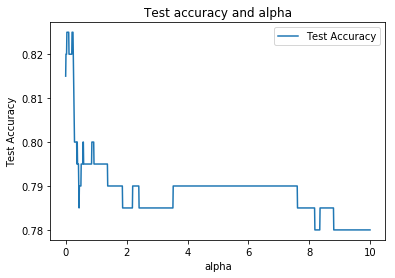

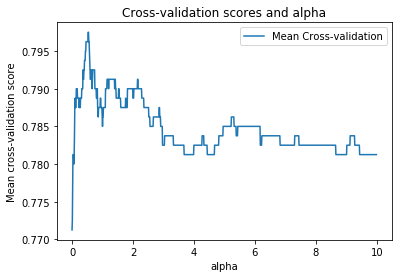

In [39]:
models.plot(x='alpha', y='Test Accuracy')   #plotting test accuracy as a function of alpha 
plt.ylabel('Test Accuracy')
plt.title('Test accuracy and alpha')
plt.show()

models.plot(x='alpha', y='Mean Cross-validation') 
plt.ylabel('Mean cross-validation score')
plt.title('Cross-validation scores and alpha')
plt.show()

Similarly, the next iteration hypertuning suggests that the alpha should be close to 2. 

In [41]:
list_alpha = np.arange(1e-5, 1, .001)
train_score = np.zeros(len(list_alpha))
test_score = np.zeros(len(list_alpha))
test_precision = np.zeros(len(list_alpha))
test_recall = np.zeros(len(list_alpha))
CV_score = np.zeros(len(list_alpha))

count = 0 
for alpha in list_alpha:
    bnb = sklearn.naive_bayes.BernoulliNB(alpha=alpha)
    bnb.fit(Xtf_train, ytf_train)
    train_score[count] = bnb.score(Xtf_train, ytf_train)
    test_score[count] = bnb.score(Xtf_test, ytf_test)
    test_precision[count] = metrics.precision_score(ytf_test, bnb.predict(Xtf_test))
    test_recall[count] = metrics.recall_score(ytf_test, bnb.predict(Xtf_test))
    CV_score[count] = (cross_val_score(bnb, Xtf_train, ytf_train, cv=10)).mean()
    count+= 1


In [42]:
matrix = np.matrix(np.c_[list_alpha, train_score, test_score, test_precision, test_recall, CV_score])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Mean Cross-validation'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Mean Cross-validation
0,0.00001,0.98,0.815,0.8,0.84,0.77125
1,0.00101,0.98,0.815,0.8,0.84,0.77250
2,0.00201,0.98,0.815,0.8,0.84,0.77250
3,0.00301,0.98,0.815,0.8,0.84,0.77250
4,0.00401,0.98,0.815,0.8,0.84,0.77125
5,0.00501,0.98,0.815,0.8,0.84,0.77125
6,0.00601,0.98,0.815,0.8,0.84,0.77250
7,0.00701,0.98,0.815,0.8,0.84,0.77250
8,0.00801,0.98,0.815,0.8,0.84,0.77250
9,0.00901,0.98,0.815,0.8,0.84,0.77250


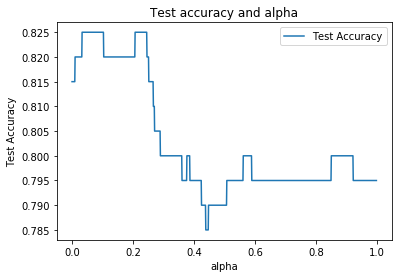

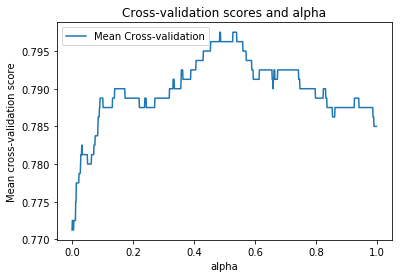

In [43]:
models.plot(x='alpha', y='Test Accuracy')   #plotting test accuracy as a function of alpha 
plt.ylabel('Test Accuracy')
plt.title('Test accuracy and alpha')
plt.show()

models.plot(x='alpha', y='Mean Cross-validation') 
plt.ylabel('Mean cross-validation score')
plt.title('Cross-validation scores and alpha')
plt.show()

In [45]:
scores = cross_val_score(bnb, Xtf_train, ytf_train, cv=10)
print("Mean 10-fold cross-validated accuracy from Bernoulli NB with tfidf: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() *2))  #means
# 69% was 56%
print(bayes.alpha)

Mean 10-fold cross-validated accuracy from Bernoulli NB with tfidf: 0.78 (+/- 0.11)
1.99001


The model performs better when the alpha is around .5 for the cross-validated data. Thus, this iteration runs the model on alpha .5.  